## Implementation Adaptive PCA and Image denoising

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from measure import compute_psnr, compute_ssim
from utils import add_noisy, transform_wavelet

In [2]:
_IMG_PATH = '../images/lena512.bmp'

In [3]:
img = cv2.imread(_IMG_PATH)
img.shape

(512, 512, 3)

In [29]:
hyper_params = {}
hyper_params['origin_size'] = img.shape[:2]
hyper_params['patch_size'] = 7
hyper_params['train_region_size'] = 20
hyper_params['n_components'] = 250
hyper_params['var_noise'] = 25
hyper_params['stride_overlap'] = 1
hyper_params['eps'] = 1e-23

In [5]:
# hyper_params

In [6]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

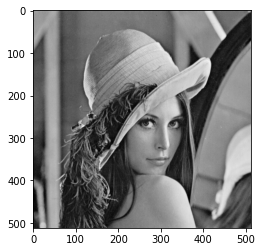

In [7]:
plt.imshow(img_gray, cmap='gray')

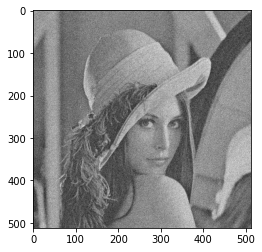

In [8]:
img_noise, noise = add_noisy(img_gray, var=hyper_params['var_noise']**2)
plt.imshow(img_noise, cmap='gray')

In [9]:
y_coeffs = transform_wavelet(img_noise)
var_noise_est = np.median(np.abs(y_coeffs[-1][-1]))/0.6745
var_noise_est

25.350822495904183

In [10]:
def divide_patches(I, patch_size = (7,7)):
    """
    I is the image function
    """
    patches_array = np.lib.stride_tricks.sliding_window_view(I, (7,7))
    patches_array_rot = np.moveaxis(patches_array, 0, 1)
    training_region = patches_array_rot.reshape(
                                (patches_array_rot.shape[0]*patches_array_rot.shape[1],
                                 patches_array_rot.shape[2]*patches_array_rot.shape[3]))
    return training_region

In [11]:
def define_centroid_patches(hyper_params, I):
    """
    I is the image function
    """
    ## define size of mask follow size of feature map
    ## mask is the array of centroids of patches
    centroids_width = int((I.shape[0] - hyper_params['patch_size'])/hyper_params['stride_overlap']) + 1
    centroids_height = int((I.shape[1] - hyper_params['patch_size'])/hyper_params['stride_overlap']) + 1
    total_num_centroids = centroids_width*centroids_height
    
    ## define index matrix of the centroids array
    centroids_map_index = np.arange(total_num_centroids)
    centroids_map_index = centroids_map_index.reshape((centroids_height, centroids_width)).T
    
    return centroids_map_index, centroids_width, centroids_height

In [12]:
def get_principal_components(centroids_map_index, 
                      training_region, 
                      current_row, 
                      current_col,
                      current_centroid_idx,
                      hyper_params):
    
    [centroids_width, centroids_height] = centroids_map_index.shape

    rmin = max(current_row - hyper_params['train_region_size'], 0)
    rmax = min(current_row + hyper_params['train_region_size'] + 1, centroids_width)
    cmin = max(current_col - hyper_params['train_region_size'], 0)
    cmax = min(current_col + hyper_params['train_region_size'] + 1, centroids_height)

    idx = centroids_map_index[rmin: rmax, cmin: cmax]
    idx = (idx.T).flatten()
    
    ## training_region has size of 506*506*7*7
    ## training_set has size 21*21*7*7
    training_set = training_region[idx,:]
    
    ## denoise_region is signal with noise in middle 7*7
    denoise_region = training_region[current_centroid_idx,:]
    
    ## calculate distance to selecting principal components
    init_distance = (training_set[:, 0] - denoise_region[0])**2
    init_distance = init_distance.reshape((init_distance.shape[0], 1))

    for k in range(1, training_region.shape[1]):
        partial_distance = (training_set[:, k] - denoise_region[k])**2
        partial_distance = partial_distance.reshape((partial_distance.shape[0], 1))
        init_distance += partial_distance

    components_distance = init_distance/training_region.shape[1]
    components_distance_sort = np.argsort(components_distance, axis=0)
    
    pc_index = idx[components_distance_sort[0:hyper_params['n_components']]]

    return pc_index

In [13]:
def pca_transform(X):
    """
    tranform from spatial domain to PCA domain
    param:
        X: MxN matrix (M dimensions, N trials)
    return:
        Y: Y=P*X
        P: the transform matrix
        V: the variance vector
    """
    [M, N] = X.shape

    mx = (np.mean(X, axis=1)).reshape((M, 1))

    X = X - mx

    CovX = np.matmul(X,X.T) / (N-1)
    
    [V, P]= np.linalg.eig(CovX)

    V_minus = -1 * V
    ind = np.argsort(V_minus, axis=0)

    V = V[ind];
    P = P[:, ind]

    P = P.T
    Y = np.matmul(P, X)

    return [Y, P, V, mx]

In [14]:
centroids_map_index, centroids_width, centroids_height = define_centroid_patches(hyper_params, img_noise)
training_region = divide_patches(img_noise)

In [26]:
denoise_set = np.zeros(training_region.T.shape)
print('*'*10,'Training','*'*10)

with tqdm(total = centroids_width * centroids_height) as pbar:
    for i in range(centroids_width):
        for j in range(centroids_height):

            current_row = i
            current_col = j

            current_centroid_idx = current_col*centroids_width + current_row

            pc_idx = get_principal_components(centroids_map_index, 
                          training_region, 
                          current_row, 
                          current_col,
                          current_centroid_idx,
                          hyper_params)

            pc_idx = pc_idx.flatten()

            [coe, P, V, mX] = pca_transform(training_region.T[:, pc_idx])

            py = np.mean(coe**2, axis=1)
            py = py.reshape((py.shape[0], 1))

            ## The variance of xi is estimated using the maximum likelihood estimator
            px = np.maximum(np.zeros(py.shape), py - var_noise_est**2)

            ## The LMMSE estimator for xi is xi = k*yi
            wei = px/py

            partial = ((coe[:, 0]).T * (wei.T)).T
            partial2 = np.matmul(P.T, partial)
            partial3 = mX[:, 0]
            partial3 = partial3.reshape((partial3.shape[0], 1))

            denoise_set[:, current_centroid_idx] = (partial2 + partial3)[:, 0]
            pbar.update(1)

********** Training **********


100%|██████████| 256036/256036 [08:20<00:00, 511.98it/s]


In [30]:
print('*'*10,'Reconstructing','*'*10)

img_recon = np.zeros(hyper_params['origin_size'])
img_wei = np.zeros(hyper_params['origin_size'])
row_idx = np.arange(0, centroids_width, 1)
col_idx = np.arange(0, centroids_height, 1)

k = 0
for i in range(hyper_params['patch_size']):
    for j in range(hyper_params['patch_size']):
        rv, cv = np.meshgrid(row_idx+i, col_idx+j)
        img_recon[rv, cv] = img_recon[rv, cv] + (denoise_set[k, :].T).reshape((centroids_width, centroids_height))
        img_wei[rv, cv] = img_wei[rv, cv] + 1
        k+=1
img_denoise = img_recon/(img_wei + hyper_params['eps'])

********** Reconstructing **********


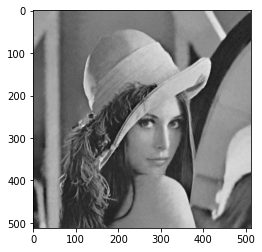

In [31]:
plt.imshow(img_denoise, cmap='gray')

In [32]:
compute_psnr(img_gray, img_noise), compute_psnr(img_gray, img_denoise)

(20.163036201582933, 30.591384647392733)

In [33]:
compute_ssim(img_gray, img_noise), compute_ssim(img_gray, img_denoise)

(0.271041562669727, 0.7672744008643599)